# Import modules

In [1]:
!pip install wget
!pip install glob

  Preparing metadata (setup.py) ... done
  Created wheel for wget: filename=wget-3.2-py3-none-any.whl size=9656 sha256=b3df4e61966931d187dc3e326fb8f58d3529f7e3f4268981dbbbe4a25b4dc1e7
  Stored in directory: /root/.cache/pip/wheels/8b/f1/7f/5c94f0a7a505ca1c81cd1d9208ae2064675d97582078e6c769
Successfully built wget
ERROR: Could not find a version that satisfies the requirement glob (from versions: none)
ERROR: No matching distribution found for glob


In [2]:
import wget
import zipfile
import os
import glob
import numpy as np
import pandas as pd
import tensorflow as tf
import librosa
import matplotlib.pyplot as plt

#Download and extract dataset

In [3]:
wget.download("http://storage.googleapis.com/download.tensorflow.org/data/mini_speech_commands.zip")

'mini_speech_commands.zip'

In [4]:
zip_ref = zipfile.ZipFile('/content/mini_speech_commands.zip', 'r')
zip_ref.extractall('/content')
zip_ref.close()
print(os.listdir(), os.listdir('mini_speech_commands'), os.listdir('mini_speech_commands/yes'), sep = '\n')

['.config', 'mini_speech_commands', '__MACOSX', 'mini_speech_commands.zip', 'sample_data']
['yes', 'right', 'no', 'stop', 'down', 'go', 'up', 'left', 'README.md']
['f953e1af_nohash_3.wav', '0ac15fe9_nohash_0.wav', '5c8af87a_nohash_1.wav', '8d9cc260_nohash_2.wav', 'd0faf7e4_nohash_1.wav', 'fe1916ba_nohash_1.wav', '1cc80e39_nohash_0.wav', 'f550b7dc_nohash_0.wav', '8a28231e_nohash_2.wav', '3389305e_nohash_1.wav', '8ea22de7_nohash_1.wav', '65079685_nohash_0.wav', '48a9f771_nohash_0.wav', '8a56f36e_nohash_0.wav', '2796ac50_nohash_1.wav', 'c1d39ce8_nohash_2.wav', '6727b579_nohash_0.wav', '90b94017_nohash_0.wav', 'a5d485dc_nohash_0.wav', '4290ca61_nohash_0.wav', 'b9db6e42_nohash_0.wav', '300384f0_nohash_0.wav', '105a0eea_nohash_0.wav', '28ed6bc9_nohash_3.wav', '2cec1d47_nohash_0.wav', 'a2fefcb4_nohash_0.wav', '24632875_nohash_1.wav', '2197f41c_nohash_0.wav', '1c6e5447_nohash_0.wav', '40115b19_nohash_1.wav', 'e96a5020_nohash_0.wav', 'dbb7723a_nohash_0.wav', 'dea820ce_nohash_2.wav', 'ffd2ba2f_n

#Visualise sample audio

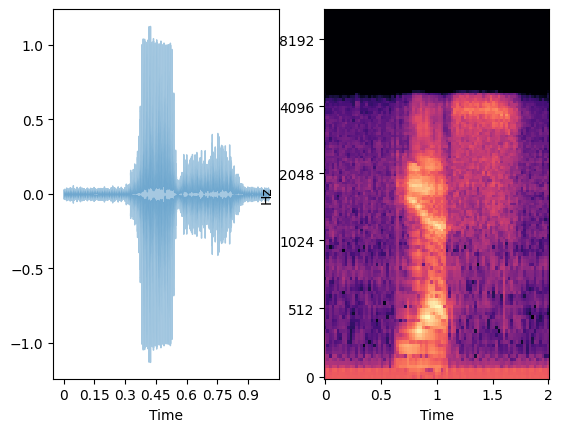

In [5]:
audio, sr = librosa.load('mini_speech_commands/yes/0ac15fe9_nohash_0.wav', sr = 44100, mono = True)
fig, ax = plt.subplots(1,2)
plt.subplot(1,2,1)
librosa.display.waveshow(audio, sr = sr, alpha=0.4)
plt.subplot(1,2,2)
mel_spectrogram = librosa.feature.melspectrogram(y=audio, sr=sr, n_fft=1024, hop_length=512)
mel_spectrogram = librosa.power_to_db(mel_spectrogram, ref=np.max)
librosa.display.specshow(mel_spectrogram, y_axis='mel', x_axis='time')
plt.show()

In [6]:
print(mel_spectrogram)

[[-32.63741  -27.841562 -28.268536 ... -27.365864 -27.74587  -28.955196]
 [-33.32238  -28.018156 -29.178457 ... -28.111403 -28.252665 -29.478096]
 [-33.818214 -27.295713 -30.410023 ... -28.789806 -28.264738 -29.530972]
 ...
 [-80.       -80.       -80.       ... -80.       -80.       -80.      ]
 [-80.       -80.       -80.       ... -80.       -80.       -80.      ]
 [-80.       -80.       -80.       ... -80.       -80.       -80.      ]]


#Load data from dataset and preprocess it

In [7]:
commands = ['yes', 'right', 'no', 'stop', 'down', 'go', 'up', 'left']
df = pd.DataFrame(columns = ('audio', 'text'))
samples = pd.DataFrame(columns = ('audio', 'text'))

for command in commands:
 for filename in os.listdir('mini_speech_commands/' + command):
  audio, sr = librosa.load('mini_speech_commands/'+command+'/'+filename, sr = 44100, mono = True)
  if len(audio) < 44100:
    samples = pd.concat((samples, pd.DataFrame( ((audio, command),), columns = ('audio', 'text'))))
  audio = audio.copy()
  audio.resize(44100)
  mel_spectrogram = librosa.feature.melspectrogram(y=audio, sr=sr, n_fft=1024, hop_length=512)
  mel_spectrogram = librosa.power_to_db(mel_spectrogram, ref=np.max).reshape((128,87,1))
  new_data = pd.DataFrame( ((mel_spectrogram, command),), columns = ('audio', 'text'))
  df = pd.concat((df, new_data))

df

,audio,text
0,"[[[-77.12065], [-76.70184], [-78.16722], [-78....",yes
0,"[[[-32.63741], [-27.841562], [-28.268536], [-2...",yes
0,"[[[-80.0], [-78.78871], [-80.0], [-77.33365], ...",yes
0,"[[[-28.68789], [-31.772316], [-27.998074], [-2...",yes
0,"[[[-58.916164], [-52.75513], [-53.535103], [-5...",yes
...,...,...
0,"[[[-69.776855], [-71.414955], [-70.087616], [-...",left
0,"[[[-38.089012], [-57.53762], [-47.159195], [-5...",left
0,"[[[-33.403793], [-29.064983], [-28.110565], [-...",left
0,"[[[-19.14095], [-15.419655], [-15.115244], [-1...",left


In [8]:
def one_hot_enc(word):
 d = {'yes':0, 'right':1, 'no':2, 'stop':3, 'down':4, 'go':5, 'up':6, 'left':7}
 enc = np.zeros(8, dtype=np.int8)
 enc[d[word]] = 1
 return enc

df['text'] = df['text'].apply(one_hot_enc)
df

,audio,text
0,"[[[-77.12065], [-76.70184], [-78.16722], [-78....","[1, 0, 0, 0, 0, 0, 0, 0]"
0,"[[[-32.63741], [-27.841562], [-28.268536], [-2...","[1, 0, 0, 0, 0, 0, 0, 0]"
0,"[[[-80.0], [-78.78871], [-80.0], [-77.33365], ...","[1, 0, 0, 0, 0, 0, 0, 0]"
0,"[[[-28.68789], [-31.772316], [-27.998074], [-2...","[1, 0, 0, 0, 0, 0, 0, 0]"
0,"[[[-58.916164], [-52.75513], [-53.535103], [-5...","[1, 0, 0, 0, 0, 0, 0, 0]"
...,...,...
0,"[[[-69.776855], [-71.414955], [-70.087616], [-...","[0, 0, 0, 0, 0, 0, 0, 1]"
0,"[[[-38.089012], [-57.53762], [-47.159195], [-5...","[0, 0, 0, 0, 0, 0, 0, 1]"
0,"[[[-33.403793], [-29.064983], [-28.110565], [-...","[0, 0, 0, 0, 0, 0, 0, 1]"
0,"[[[-19.14095], [-15.419655], [-15.115244], [-1...","[0, 0, 0, 0, 0, 0, 0, 1]"


In [9]:
spectrograms = np.stack(df['audio'])
words = np.stack(df['text'])
dataset = tf.data.Dataset.from_tensor_slices((spectrograms, words))
dataset = dataset.shuffle(8000)

train_ds = dataset.take(7000).shuffle(7000, reshuffle_each_iteration = True).batch(32).prefetch(tf.data.AUTOTUNE)
val_ds = dataset.skip(7000).take(750).batch(32).prefetch(tf.data.AUTOTUNE)
test_ds = dataset.skip(7750).batch(32).prefetch(tf.data.AUTOTUNE)

train_ds

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 128, 87, 1), dtype=tf.float32, name=None), TensorSpec(shape=(None, 8), dtype=tf.int8, name=None))>

#Create a model and train it

In [10]:
model = tf.keras.Sequential([
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=(128, 87, 1)),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(8, activation='softmax')
])
model.summary()

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 126, 85, 32)         │             320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 63, 42, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 61, 40, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 30, 20, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 38400)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │       4,915,328 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 8)                   │           1,032 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 4,935,176 (18.83 MB)

 Trainable params: 4,935,176 (18.83 MB)

 Non-trainable params: 0 (0.00 B)

In [11]:
model.predict(mel_spectrogram.reshape(1,128, 87, 1))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 213ms/step


array([[1.1207965e-01, 8.1719865e-12, 8.8771737e-01, 1.2891239e-10,
        1.6185060e-05, 1.1221876e-09, 3.0521750e-12, 1.8675879e-04]],
      dtype=float32)

In [12]:
model.compile(optimizer='adam', loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True), metrics=['accuracy'])
history = model.fit(train_ds, epochs=12, validation_data=val_ds, validation_steps=30)

Epoch 1/12


/usr/local/lib/python3.10/dist-packages/keras/src/backend/tensorflow/nn.py:593: UserWarning: "`categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


219/219 ━━━━━━━━━━━━━━━━━━━━ 121s 543ms/step - accuracy: 0.3499 - loss: 13.5783 - val_accuracy: 0.8067 - val_loss: 0.5919
Epoch 2/12


/usr/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


219/219 ━━━━━━━━━━━━━━━━━━━━ 145s 559ms/step - accuracy: 0.8183 - loss: 0.5384 - val_accuracy: 0.9040 - val_loss: 0.2870
Epoch 3/12
219/219 ━━━━━━━━━━━━━━━━━━━━ 133s 518ms/step - accuracy: 0.8955 - loss: 0.3085 - val_accuracy: 0.9293 - val_loss: 0.2077
Epoch 4/12
219/219 ━━━━━━━━━━━━━━━━━━━━ 113s 517ms/step - accuracy: 0.9420 - loss: 0.1750 - val_accuracy: 0.9573 - val_loss: 0.1481
Epoch 5/12
219/219 ━━━━━━━━━━━━━━━━━━━━ 111s 508ms/step - accuracy: 0.9689 - loss: 0.1037 - val_accuracy: 0.9787 - val_loss: 0.0685
Epoch 6/12
219/219 ━━━━━━━━━━━━━━━━━━━━ 115s 524ms/step - accuracy: 0.9806 - loss: 0.0716 - val_accuracy: 0.9853 - val_loss: 0.0546
Epoch 7/12
219/219 ━━━━━━━━━━━━━━━━━━━━ 147s 549ms/step - accuracy: 0.9763 - loss: 0.0698 - val_accuracy: 0.9627 - val_loss: 0.1074
Epoch 8/12
219/219 ━━━━━━━━━━━━━━━━━━━━ 112s 514ms/step - accuracy: 0.9768 - loss: 0.0790 - val_accuracy: 0.9733 - val_loss: 0.0818
Epoch 9/12
219/219 ━━━━━━━━━━━━━━━━━━━━ 142s 516ms/step - accuracy: 0.9844 - loss: 0.05

#Test the model and plot metrics

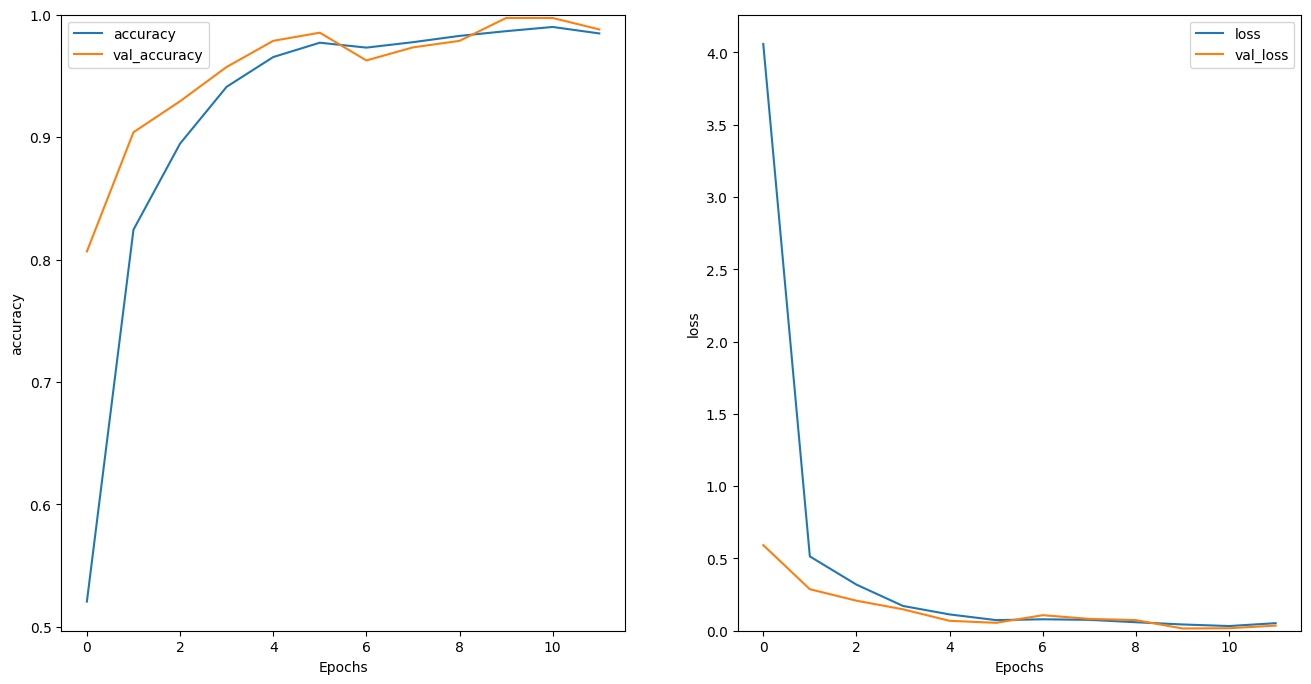

In [13]:
def plot_graphs(history, metric):
  plt.plot(history.history[metric])
  plt.plot(history.history['val_'+metric], '')
  plt.xlabel("Epochs")
  plt.ylabel(metric)
  plt.legend([metric, 'val_'+metric])

def plot_metrics(history):
  plt.figure(figsize=(16, 8))
  plt.subplot(1, 2, 1)
  plot_graphs(history, 'accuracy')
  plt.ylim(None, 1)
  plt.subplot(1, 2, 2)
  plot_graphs(history, 'loss')
  plt.ylim(0, None)

plot_metrics(history)

In [14]:
def test(model, test_ds):
  #test_dataset = test_ds.batch(64).prefetch(tf.data.AUTOTUNE)
  test_loss, test_acc = model.evaluate(test_ds)
  print("Loss :", test_loss, "\nAccuracy : ", test_acc)

test(model, test_ds)

8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 115ms/step - accuracy: 0.9971 - loss: 0.0174
Loss : 0.024521563202142715 
Accuracy :  0.9919999837875366


In [15]:
model.save_weights("command_recogniser.weights.h5")

from google.colab import files

files.download('command_recogniser.weights.h5')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [17]:
def preprocess(audio):
  audio = audio.copy()
  audio.resize(44100)
  mel_spec = librosa.feature.melspectrogram(y=audio, sr=sr, n_fft=1024, hop_length=512)
  mel_spec = librosa.power_to_db(mel_spec, ref=np.max).reshape((128,87,1))
  return mel_spec

def predict(audios, answers):
  audios = audios.apply(preprocess)
  audios = np.stack(audios)
  predictions = model.predict(audios).tolist()
  words = []

  for prediction in  predictions:
    m = max(prediction)
    for i in range(8):
      if prediction[i] == m:
        words.append(commands[i])

  words = pd.Series(words, name='text')
  answers = answers.reset_index()['text']
  print("Predictions :\n", words)
  print("\nAnswers: \n", answers)
  total = words.count()
  right = (words == answers).sum()
  print("\nTotal :", total, "\nRight :", right, "\nPercent : ", right/total*100)



predict(samples['audio'], samples['text'])

26/26 ━━━━━━━━━━━━━━━━━━━━ 3s 118ms/step
Predictions :
 0       yes
1       yes
2       yes
3       yes
4       yes
       ... 
817    left
818    left
819    left
820    left
821    left
Name: text, Length: 822, dtype: object

Answers: 
 0       yes
1       yes
2       yes
3       yes
4       yes
       ... 
817    left
818    left
819    left
820    left
821    left
Name: text, Length: 822, dtype: object

Total : 822 
Right : 808 
Percent :  98.29683698296837
